# Esercitazione 5 - Topic Modelling

Studenti:

- Brunello Matteo (mat. 858867)
- Caresio Lorenzo (mat. 836021)

*Consegna*: si richiede un'implementazione di un esercizio di Topic Modeling, utilizzando librerie open (come ad es. GenSim (https://radimrehurek.com/gensim/). Si richiede l'utilizzo di un corpus di almeno 1k documenti. Testare un algoritmo (ad esempio LDA) con più valori di k (num. di topics) e valutare la coerenza dei risultati, attraverso fine-tuning su parametri e pre-processing. Update: essendo che spesso i topic, per essere interpretabili, devono contenere content words, potete pensare di filtrare solamente i sostantivi in fase di preprocessing (cioè POS=noun).

### Caricamento e preprocessing del dataset

Per lo svolgimento dell'esercitazione seguente, è stato scelto il dataset 20 News Groups, costituito da articoli di giornale provenienti da $20$ diverse categorie. Tali categorie potranno essere utilizzate successivamente anche per validare eventualmente i risultati.

Iniziamo col defnire una semplice funzione per caricare e preprocessare il dataset in questione. Siccome il dataset contiene circa 11.000 documenti, ci concentreremo solamente in un sottoinsieme di esso ($\approx 1.000$ documenti).
Per ottenere risultati più soddisfacenti, è necessario preprocessare il sottoinsieme del dataset ottenuto per mezzo della funzione `preprocess(document)`. Tale funzione si occupa di preprocessare un singolo documento, considerando inizialmente solamente le parole composte solo da lettere. Successivaente, vengono filtrate da questo insieme tutte le parole che non sono dei sostantivi, dal momento che le parole che non sono sostantivi non sono ritenute utili ai fini dell'identificazione del topic.

La funzione `load_dataset(size)` carica il dataset, ne considera solo un sottoinsieme di grandezza stabilita, applicando successivamente ad ogni documento la fase di preprocessing. Infine, ritorna il dataset preprocessato.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from tqdm.notebook import tqdm
import spacy
import re

# Load spacy tokenizer
nlp = spacy.load("en_core_web_sm")

# Preprocess a single document
def preprocess(document):
  # Select only words (excluding numbers and other artifacts) from the text
  pattern = pattern = re.compile(r'[^a-z]+')
  document = pattern.sub(' ', document.lower())
  # Select only lemmas from the selected words
  return [t.lemma_ for t in nlp(document) if t.pos_ == 'NOUN' and len(t.lemma_) > 3]

# Load and preprocess the dataset
def load_dataset(size = 1000):
  print('Loading dataset...')
  # Load 20newsgroups, removing headers, footers and quotes from the corpus
  dataset = fetch_20newsgroups(
    remove = ('headers', 'footers', 'quotes'),
    shuffle = True,
    random_state = 42
  )
  # Return the processed dataset
  return [preprocess(text) for text in tqdm(dataset.data[:size])], dataset.target_names

### Addestramento del modello

Prima di tutto è necessario caricare il dataset per mezzo della funzione creata in precedenza. Secondo la documentazione di `gensim`, è inoltre necessario creare a partire dal dataset un *dizionario* e un *corpus* da utilizzare in seguito per la fase di addestramento del modello.

**Nota bene**: l'esecuzione della seguente cella potrebbe richiedere un tempo considerevole dovuto alla fase di preprocessing del dataset.

In [ ]:
from gensim.corpora.dictionary import Dictionary

# Load the dataset
dataset, real_topics = load_dataset()

# Creates a dictionary and a corpus from the dataset
dictionary = Dictionary(dataset)
corpus = [dictionary.doc2bow(text) for text in dataset]

Loading dataset...


  0%|          | 0/1000 [00:00<?, ?it/s]

Nonostante si conosca a priori il numero di topics (in questo caso $20$), ai fini dell'esercitazione si procederà comunque come se questo numero non fosse noto. Nonostante l'apprendimento di un modello LDA sia di tipo non supervisionato, l'algoritmo di apprendimento richiede comunque di conoscere il numero di topics a priori.

Per trovare il numero di topics ottimale si è deciso di procedere valutando una serie di modelli con numero di topics differente, per poi scegliere quello che massimizzi un determinato score, in questo caso il *coherence score*.

La seguente cella implementa ciò che è stato appena discusso. Viene considerato un numero di topics $n \in [15;25)$. Per ogni valore $n$, si addestra un modello LDA, ne si calcola il valore di coerenza per poi salvare il tutto all'interno di una lista (`ranking`). Per permettere al modello di convergerre ad una soluzione, l'algoritmo di apprendimento effettua $10$ passaggi dell'intero dataset.

**Nota bene**: l'esecuzione della seguente cella potrebbe richiedere un tempo considerevole dovuto alla fase onerosa di addestramento di un singolo modello.

In [ ]:
from gensim.models import CoherenceModel, LdaModel

# Train a series of LDA models with different number of topics, saving them
# with their corresponding coherence score in a list
ranking = []
print('Training models...')
for num_topics in tqdm(range(15, 25, 1)):
  model = LdaModel(corpus, num_topics = num_topics, id2word = dictionary, passes = 10)
  cm = CoherenceModel(model = model, dictionary = dictionary, texts = dataset)
  ranking.append((cm.get_coherence(), num_topics, model))

Training models...


  0%|          | 0/10 [00:00<?, ?it/s]

Tracciamo ora un semplice istogrammma dei vari score ottenuti per numero di topics, in modo da poter valutare visivamente quale numero di topics sia migliore.

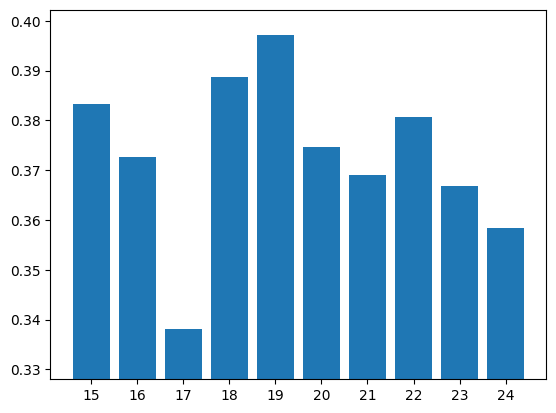

In [ ]:
import matplotlib.pyplot as plt

# Plot the scores with their corresponding number of topics
x, y = [num_topics for _, num_topics, _ in ranking], [score for score, _, _ in ranking]
plt.bar(x, y)
plt.xticks(x)
plt.ylim(min(y)-.01, max(y)+.005)
plt.show()

Il modello con *coherence score* migliore si troverà quindi nella testa della lista ordinata in ordine decrescente per *coherence score*.

In [ ]:
# Reverse sort the models ranking
ranking.sort(reverse = True)

# The best model will be at the head of the list
best_score, best_num_topics, best_model = ranking[0]

print(f'Best number of topics is {best_num_topics} with a coherence score of {best_score:0.2f}.')


Best number of topics is 19 with a coherence score of 0.40.


Una volta ottenuto il modello migliore, si visualizzano i topics che sono stati appresi. Per una visualizzazione agevole si à scelto di visualizzarli in una *Word Cloud*, modalità di visualizzazione trattata a lezione. La funzione `show_word_cloud(topics, n_rows, n_cols)` mostra una serie di topics in formato cloud of words.

Sotto la visualizzazione a *cloud of words*, vengono inoltre stampati i veri topics, in modo di poter valutare soggettivamente la qualità del risultato.

Learnt topics:


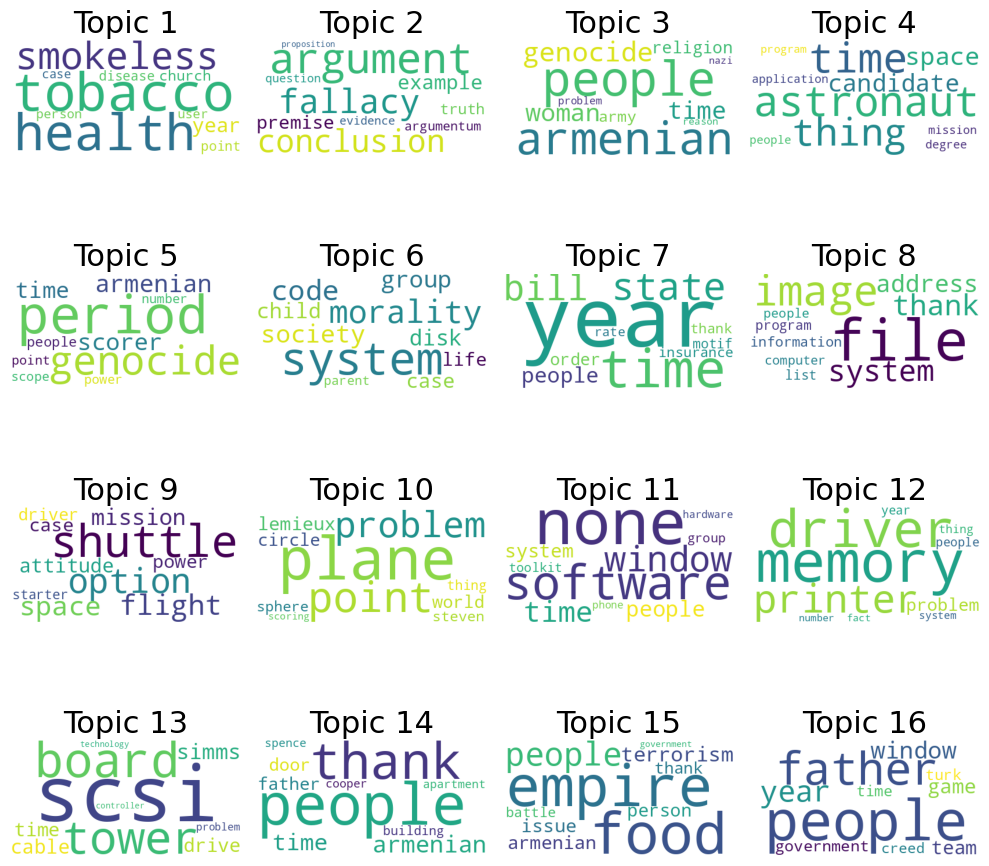

Real topics:


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
from wordcloud import WordCloud

# Get the learnt topics of the best model (this notation just gets the second element of the tuples)
topics = [t for _, t  in best_model.show_topics(formatted = False, num_topics = best_num_topics, num_words = 10)]

# Create and show a cloud of words plot
def show_word_cloud(topics, n_rows, n_cols):
  cloud = WordCloud(background_color='white', max_words=10, prefer_horizontal=True)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
  # Add to each component of the subplot the word cloud corresponding to a topic
  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      cloud.generate_from_frequencies(dict(topics[i]))
      plt.gca().imshow(cloud)
      plt.gca().axis('off')
      # Since we don't know the name of the topic, we just set it to be 0 to n_topics
      plt.gca().set_title(f'Topic {i+1}', font = { 'size': 22 })
  plt.tight_layout()
  plt.show()

# Show words cloud
print('Learnt topics:')
show_word_cloud(topics, 4, 4)

# Show real topics
print('Real topics:')
display(real_topics)